## Exploratory Data Analysis (EDA)

This notebook explores demographic and clinical patterns associated with
mortality in the COVID-19 patient dataset. The goal is to identify trends,
group-level differences, and potential risk factors through descriptive
statistics and visual analysis.

No causal claims are made at this stage.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "covid19_2021_clean.parquet"
df = pd.read_parquet(DATA_PATH)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14167460 entries, 0 to 14167459
Data columns (total 18 columns):
 #   Column               Dtype         
---  ------               -----         
 0   DEATH                Int8          
 1   SEXO                 category      
 2   EDAD                 Int16         
 3   TIPO_PACIENTE        category      
 4   UCI                  Int8          
 5   INTUBADO             Int8          
 6   NEUMONIA             Int8          
 7   DIABETES             Int8          
 8   HIPERTENSION         Int8          
 9   OBESIDAD             Int8          
 10  CARDIOVASCULAR       Int8          
 11  RENAL_CRONICA        Int8          
 12  EPOC                 Int8          
 13  ASMA                 Int8          
 14  INMUSUPR             Int8          
 15  TABAQUISMO           Int8          
 16  CLASIFICACION_FINAL  Int16         
 17  FECHA_DEF            datetime64[ns]
dtypes: Int16(2), Int8(13), category(2), datetime64[ns](1)
memory

In [6]:
df.shape
df.head()


,DEATH,SEXO,EDAD,TIPO_PACIENTE,UCI,INTUBADO,NEUMONIA,DIABETES,HIPERTENSION,OBESIDAD,CARDIOVASCULAR,RENAL_CRONICA,EPOC,ASMA,INMUSUPR,TABAQUISMO,CLASIFICACION_FINAL,FECHA_DEF
0,0,Male,26,Ambulatory,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,7,NaT
1,0,Female,34,Ambulatory,<NA>,<NA>,<NA>,0,0,0,0,0,0,0,0,0,7,NaT
2,0,Male,41,Ambulatory,<NA>,<NA>,0,0,0,0,0,0,0,0,0,1,7,NaT
3,0,Male,25,Ambulatory,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,7,NaT
4,0,Female,20,Ambulatory,<NA>,<NA>,0,0,0,0,0,0,0,0,0,0,7,NaT


### Age Group Feature Engineering

Age was discretized into clinically meaningful groups to facilitate
comparative mortality analysis across life stages.

In [17]:
df = df.copy()

df = df[(df["EDAD"] >= 0) & (df["EDAD"] <= 120)]

df["AGE_GROUP"] = pd.cut(
    df["EDAD"],
    bins=[0, 18, 40, 60, 80, 120],
    labels=["0-18", "19-40", "41-60", "61-80", "80+"],
    include_lowest=True
)

df["AGE_GROUP"].value_counts(normalize=True)


,proportion
AGE_GROUP,
19-40,0.503662
41-60,0.298595
0-18,0.095587
61-80,0.090056
80+,0.012099


### Target Variable Overview

In [7]:
df["DEATH"].value_counts(normalize=True) * 100

,proportion
DEATH,
0,97.824381
1,2.175619


<Axes: xlabel='DEATH', ylabel='count'>

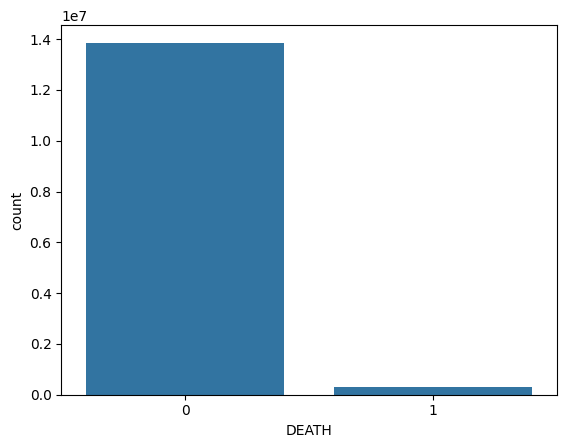

In [8]:
sns.countplot(x="DEATH", data=df)


Mortality represents a minority class, which is expected in population-level health data.


## Age Distribution & Mortality



In [22]:
df["EDAD"].describe()
df["EDAD"].value_counts().head()

,count
EDAD,
27,388880
28,382630
26,380330
29,377392
25,368748


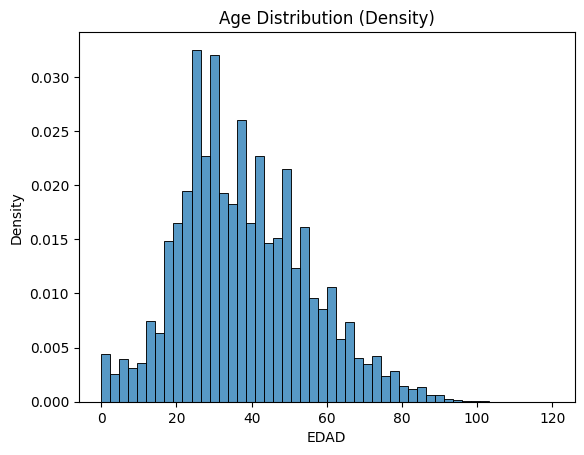

In [24]:
sns.histplot(df["EDAD"], bins=50, stat="density")
plt.title("Age Distribution (Density)")
plt.show()

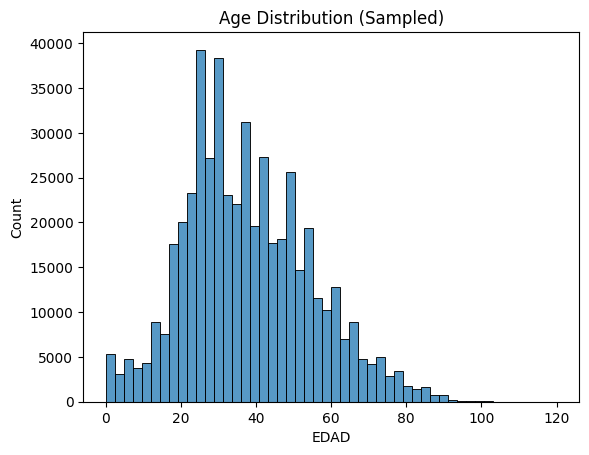

In [23]:
sample = df.sample(n=500_000, random_state=42)

sns.histplot(sample["EDAD"], bins=50)
plt.title("Age Distribution (Sampled)")
plt.show()


Due to the large size of the dataset (14M+ records), direct visualization of
continuous variables such as age may lead to misleading plots caused by scale
compression. To address this, density-based histograms and random sampling were
used to ensure meaningful visual interpretation.



In [18]:
df.groupby("AGE_GROUP")["DEATH"].mean()


/tmp/ipython-input-3494356068.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("AGE_GROUP")["DEATH"].mean()


,DEATH
AGE_GROUP,
0-18,0.002187
19-40,0.003895
41-60,0.023422
61-80,0.109995
80+,0.219325


### Demographic Factors

In [26]:
df.groupby("SEXO", observed=True)["DEATH"].mean()



,DEATH
SEXO,
Female,0.016659
Male,0.027405


Grouped statistics use `observed=True` to include only categories present
in the data and ensure future compatibility with pandas updates.

In [25]:
df.groupby("TIPO_PACIENTE", observed=True)["DEATH"].mean()

,DEATH
TIPO_PACIENTE,
Ambulatory,0.00031
Hospitalized,0.322913


<Axes: xlabel='SEXO', ylabel='DEATH'>

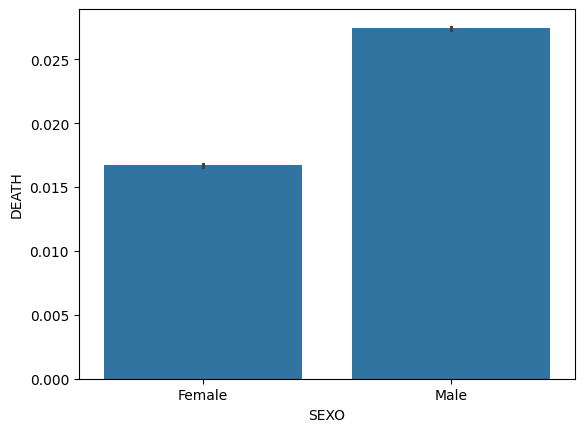

In [12]:
sns.barplot(x="SEXO", y="DEATH", data=df)


### Clinical Severity Indicators

In [14]:
severity_vars = ["NEUMONIA", "UCI", "INTUBADO"]

for col in severity_vars:
    print(col, df.groupby(col)["DEATH"].mean())


NEUMONIA NEUMONIA
0    0.007345
1    0.378444
Name: DEATH, dtype: Float64
UCI UCI
0    0.311081
1    0.495907
Name: DEATH, dtype: Float64
INTUBADO INTUBADO
0    0.285928
1    0.757094
Name: DEATH, dtype: Float64


These variables act as proxies for disease severity.

### Comorbidities & Risk Factors

In [15]:
risk_factors = [
    "DIABETES","HIPERTENSION","OBESIDAD","RENAL_CRONICA",
    "CARDIOVASCULAR","EPOC","ASMA","INMUSUPR","TABAQUISMO"
]

mortality_rates = {
    col: df[df[col] == 1]["DEATH"].mean()
    for col in risk_factors
}

pd.Series(mortality_rates).sort_values(ascending=False)


,0
RENAL_CRONICA,0.188462
EPOC,0.159320
CARDIOVASCULAR,0.129955
INMUSUPR,0.109634
DIABETES,0.105803
HIPERTENSION,0.093248
OBESIDAD,0.049920
TABAQUISMO,0.024678
ASMA,0.018638


### Correlation Analysis

<Axes: >

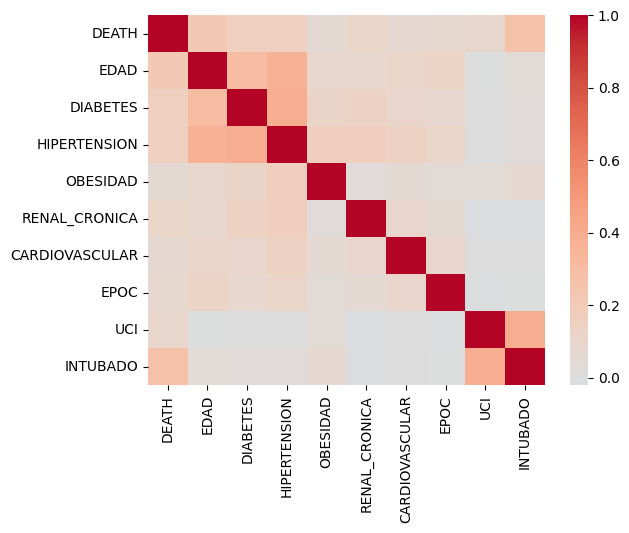

In [20]:
corr_cols = [
    "DEATH","EDAD","DIABETES","HIPERTENSION","OBESIDAD",
    "RENAL_CRONICA","CARDIOVASCULAR","EPOC","UCI","INTUBADO"
]

corr = df[corr_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0)


Correlation analysis was used as an exploratory tool. Results should be interpreted
with caution due to the binary nature of most variables.


### Outlier Analysis

In [21]:
df["EDAD"].describe(percentiles=[0.01, 0.99])


,EDAD
count,14160187.0
mean,37.779357
std,16.921105
min,0.0
1%,2.0
50%,36.0
99%,82.0
max,120.0


Outlier analysis was limited to the age variable, as most clinical features
are binary indicators. Ages outside a biologically plausible range were
excluded during preprocessing.


## Key Exploratory Findings

- Mortality strongly increases with age.
- Hospitalized patients show significantly higher mortality.
- Certain comorbidities (renal disease, diabetes, hypertension) are associated with
  increased risk of death.
- COVID-19 confirmed cases present higher mortality than non-COVID cases.
